# ARIMA scratchwork

A rough draft of working with ARIMA models.

In [99]:
from core.preprocessing import train_dev_test_split
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', palette='colorblind', context='talk')

In [4]:
df = pd.read_pickle('data/master_dataset.pkl')
df.fillna(0, inplace=True)

In [5]:
train, = train_dev_test_split(df, dev=None, test=None)
train_series = train['total_power']

In [16]:
train_series.index.date

array([datetime.date(2015, 7, 15), datetime.date(2015, 7, 15),
       datetime.date(2015, 7, 15), ..., datetime.date(2016, 11, 25),
       datetime.date(2016, 11, 25), datetime.date(2016, 11, 25)], dtype=object)

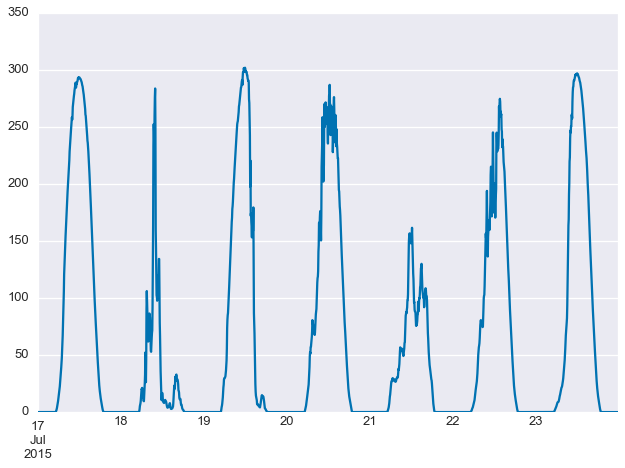

In [18]:
train_series.loc['2015-07-17':'2015-07-23'].plot()

In [211]:
def try_arma(train, order, test):
    model = SARIMAX(train, order=order)
    fit = model.fit()
    test.plot()
    for i in xrange(23):
        next_batch = test.iloc[0:12*(i+1)]
        mod2 = SARIMAX(next_batch, order=order)
        test2 = mod2.filter(fit.params)
        test2.forecast(36).plot()

In [213]:
def try_arma_exo(train, order, test):
    model = SARIMAX(train, order=order, exog=np.asarray(train.index.hour).reshape(-1,1))
    fit = model.fit()
    test.plot()
    for i in xrange(23):
        next_batch = test.iloc[0:12*(i+1)]
        mod2 = SARIMAX(next_batch, order=order, exog=np.asarray(next_batch.index.hour).reshape(-1,1))
        test2 = mod2.filter(fit.params)
        new_exog = np.asarray(test.iloc[12*(i+1):12*(i+4)].index.hour).reshape(-1,1)
        if new_exog.shape[0] == 36:
            test2.forecast(36, exog=new_exog).plot()

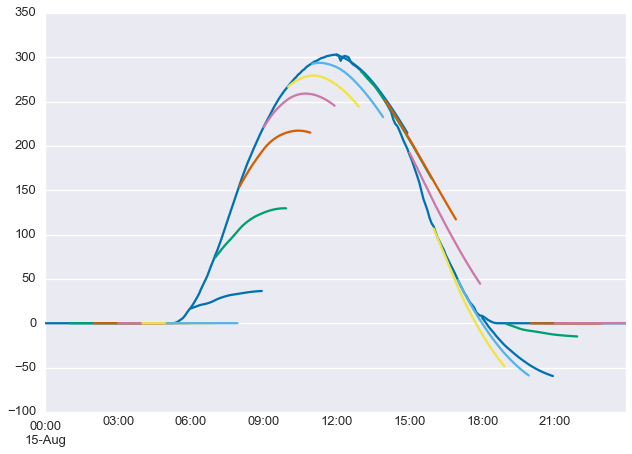

In [214]:
try_arma(train_series.loc['2015-07-17':'2015-07-30'], (12*2,0,1), train_series.loc['2015-08-15'])

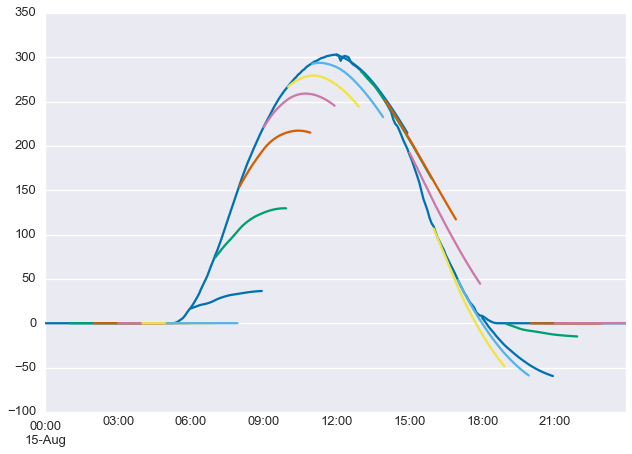

In [212]:
try_arma_exo(train_series.loc['2015-07-17':'2015-07-30'], (12*2,0,1), train_series.loc['2015-08-15'])

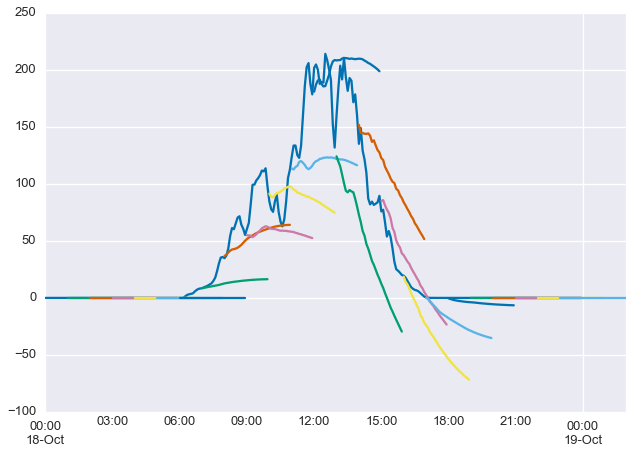

In [186]:
try_arma(train_series.loc['2015-07-17':'2015-07-30'], (12*2,0,1), train_series.loc['2015-10-18'])

In [239]:
sunny = train_series.loc['2016-4-11':'2016-4-20']
cloudy = train_series.loc['2016-1-13':'2016-1-22']
mixed = train_series.loc['2015-10-9':'2015-10-18']

In [242]:
sunny_test = train_series.loc['2015-08-15']
cloudy_test = train_series.loc['2015-10-18']

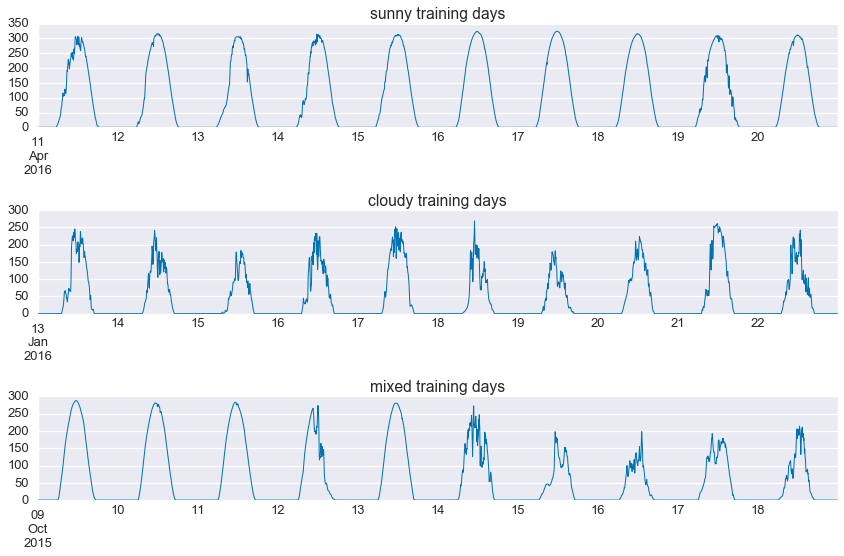

In [240]:
fig, axes = plt.subplots(nrows=3, figsize=(12,8))
sunny.plot(ax=axes[0], linewidth=1)
cloudy.plot(ax=axes[1], linewidth=1)
mixed.plot(ax=axes[2], linewidth=1)
axes[0].set_title('sunny training days')
axes[1].set_title('cloudy training days')
axes[2].set_title('mixed training days')
_ = plt.tight_layout()

In [258]:
def param_sweep(train, test, ps=[12, 18, 24, 30], ds=[0], qs=[0, 1]):
    output = {}
    for p in ps:
        output[p] = {}
        for d in ds:
            output[p][d] = {}
            for q in qs:
                output[p][d][q] = {}
                order = (p, d, q)
                model = SARIMAX(train, order=order)
                fit = model.fit()
                for i in xrange(23):
                    next_batch = test.iloc[0:12*(i+1)]
                    mod2 = SARIMAX(next_batch, order=order)
                    test2 = mod2.filter(fit.params)
                    output[p][d][q][i] = test2.forecast(36)
    return output

In [280]:
def make_plots(output_dict, test_set, figsize=(10,20)):
    keys1 = output_dict.keys()
    keys2 = output_dict[keys1[0]].keys()
    keys3 = output_dict[keys1[0]][keys2[0]].keys()
    N = len(keys1) * len(keys2) * len(keys3)
    fig = plt.figure(figsize=figsize)
    it = 1
    for p, v1 in output_dict.iteritems():
        for q, v2 in v1.iteritems():
            for r, v3 in v2.iteritems():
                ax = fig.add_subplot(N, 1, it)
                ax.set_title('p:{}, q:{}, r:{}'.format(p, q, r))
                it += 1
                test_set.plot(ax=ax)
                for v4 in v3.itervalues():
                    v4.plot(ax=ax)
    plt.tight_layout()

In [260]:
sunny_sunny = param_sweep(sunny, sunny_test)

/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


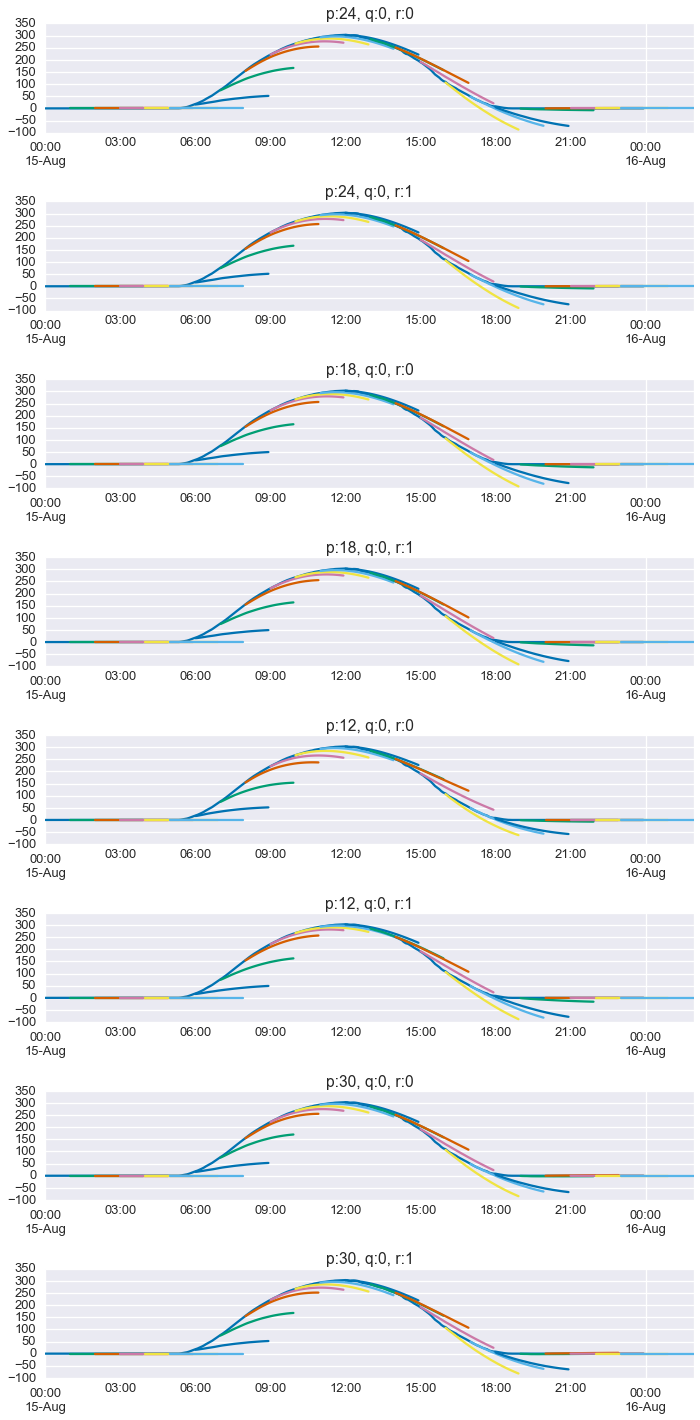

In [281]:
make_plots(sunny_sunny, sunny_test)

In [277]:
sunny_cloudy = param_sweep(sunny, cloudy_test)

/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


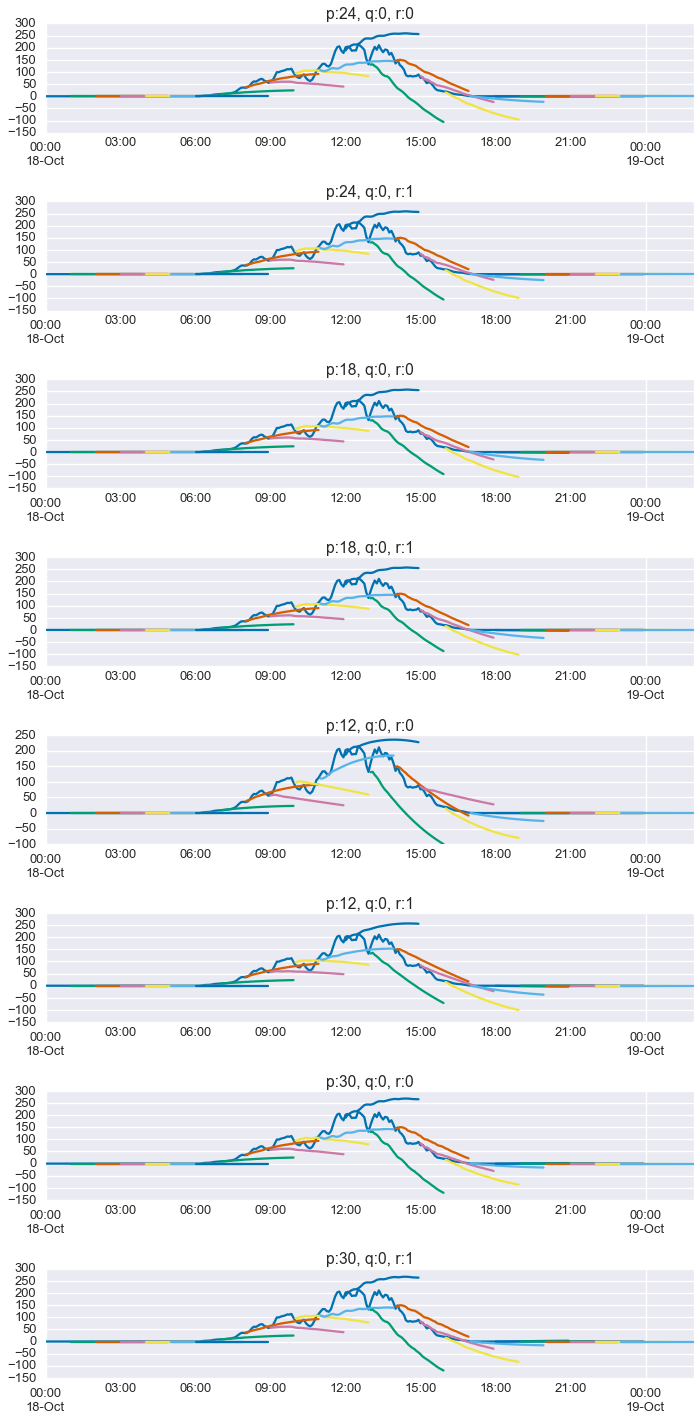

In [282]:
make_plots(sunny_cloudy, cloudy_test)

In [283]:
cloudy_cloudy = param_sweep(cloudy, cloudy_test)

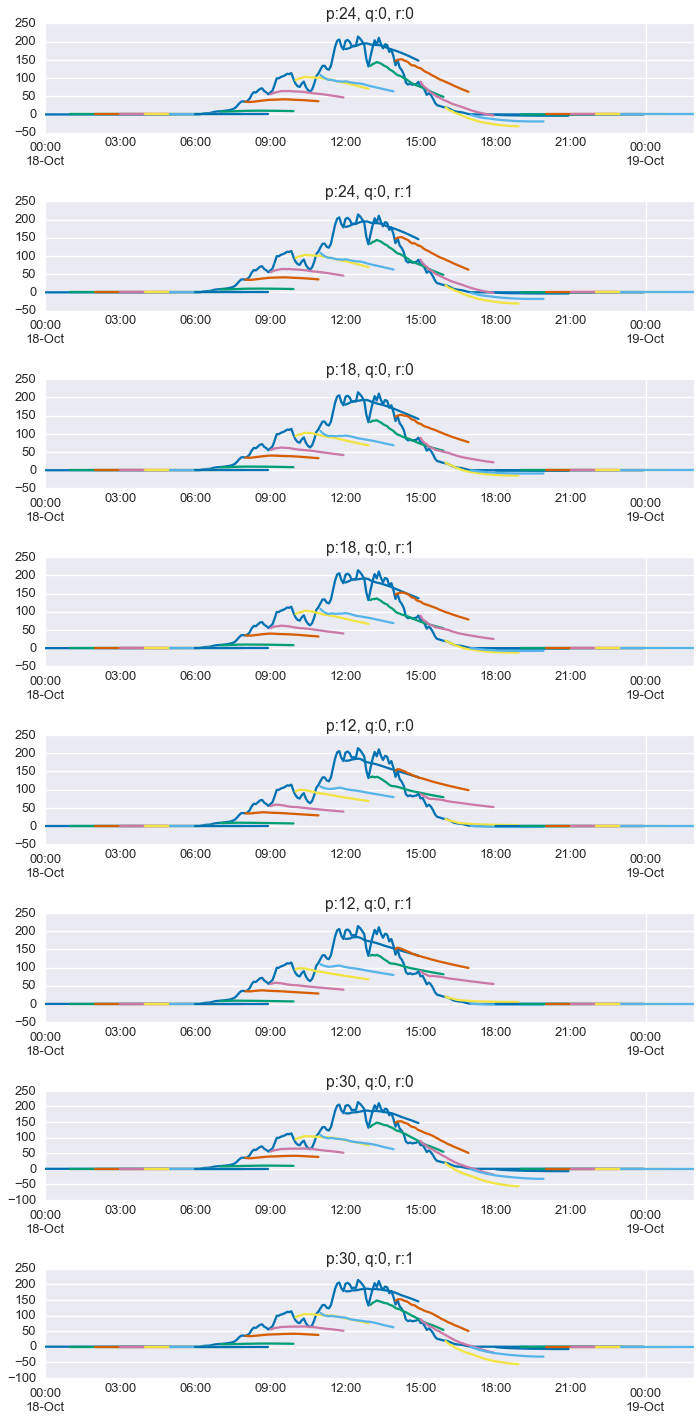

In [285]:
make_plots(cloudy_cloudy, cloudy_test)

In [286]:
cloudy_sunny = param_sweep(cloudy, sunny_test)

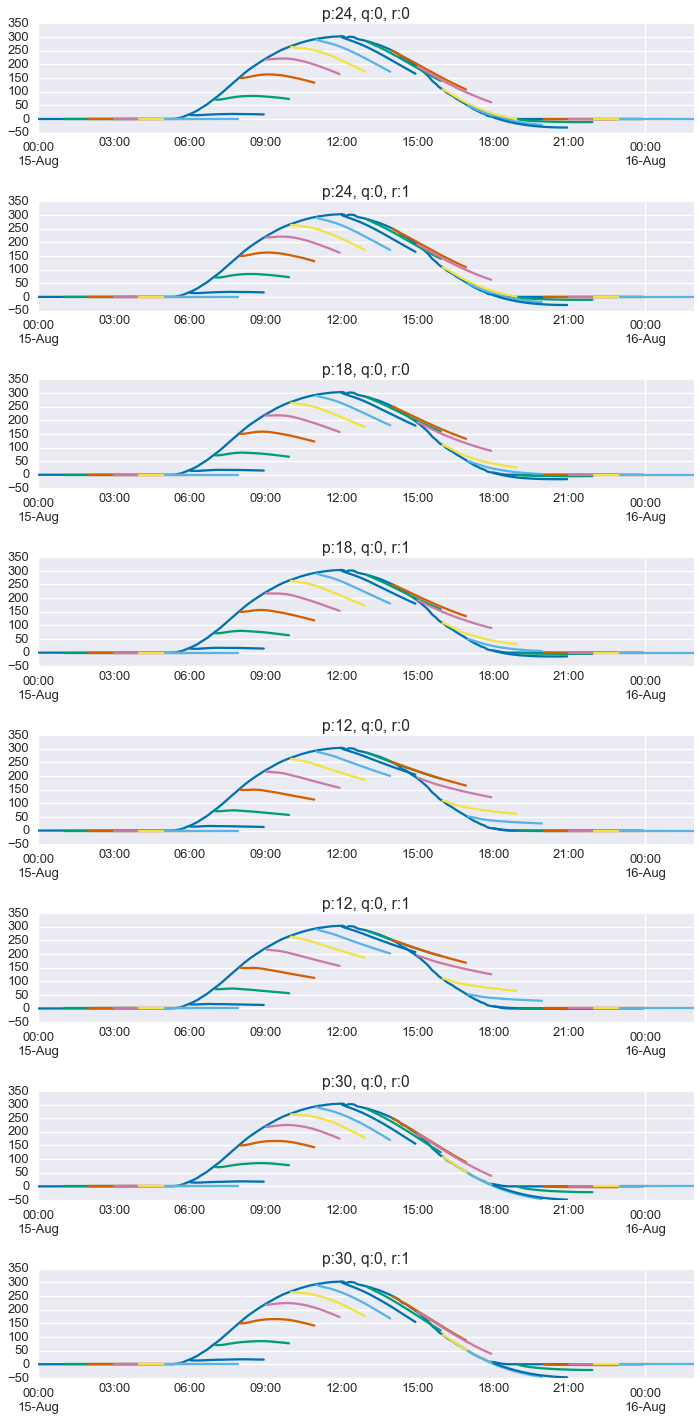

In [287]:
make_plots(cloudy_sunny, sunny_test)

In [288]:
mixed_sunny = param_sweep(mixed, sunny_test)

/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


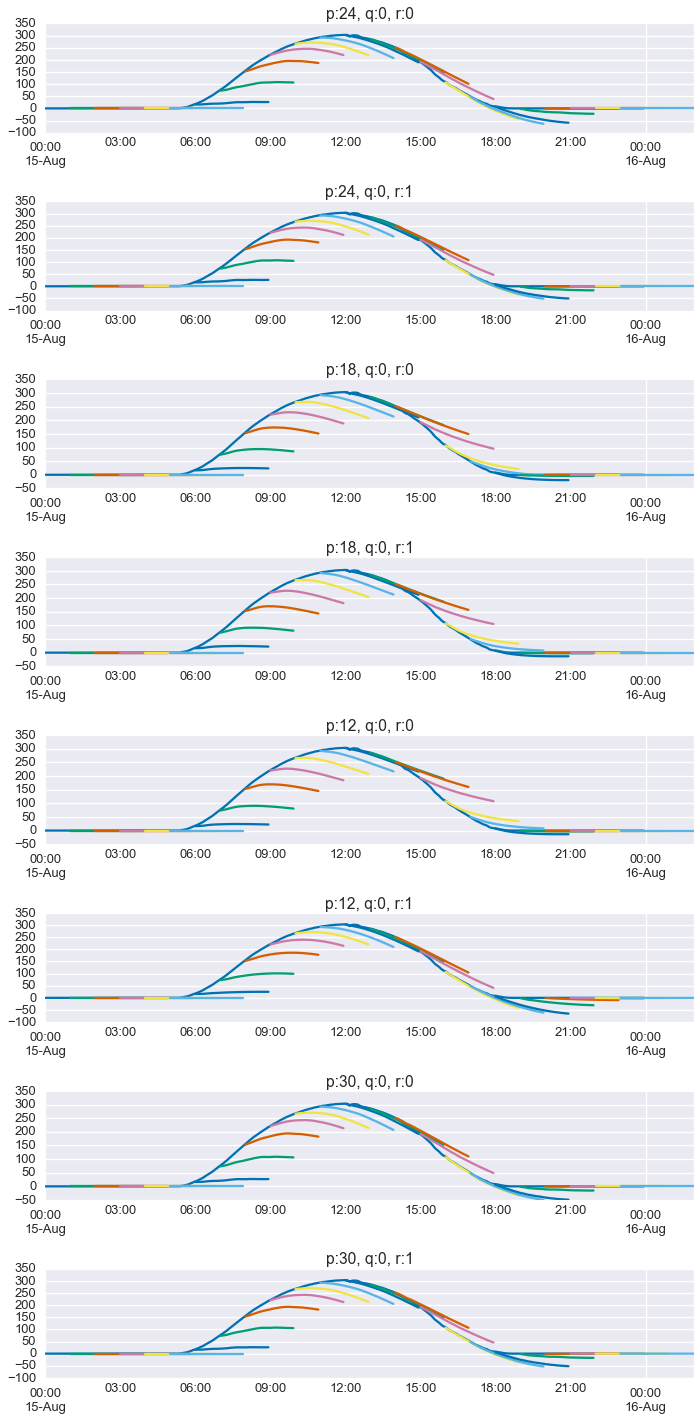

In [289]:
make_plots(mixed_sunny, sunny_test)

In [290]:
mixed_cloudy = param_sweep(mixed, cloudy_test)

/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


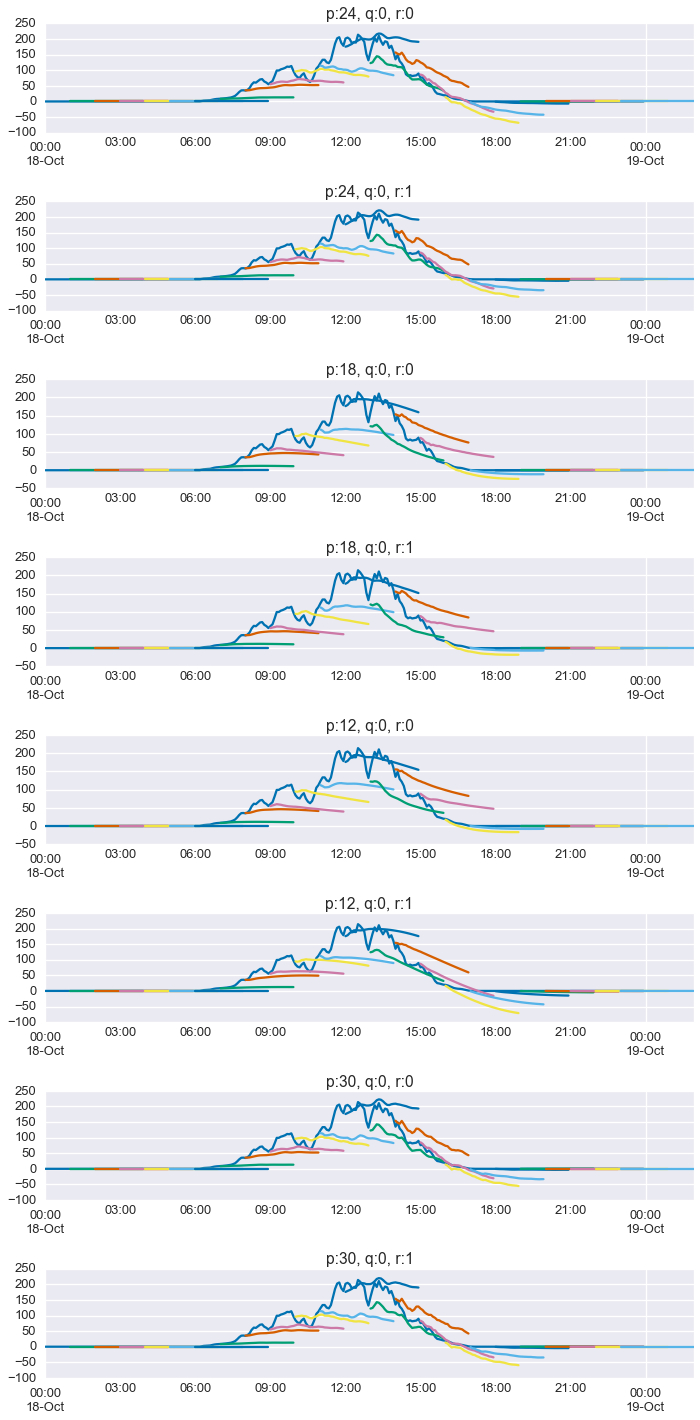

In [291]:
make_plots(mixed_cloudy, cloudy_test)